In [1]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data as mdmask
import ingest_tif_stack as ingest

In [2]:
import registerer_copy as reg
import preprocessor_copy as pre
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
atlas_resolution = 50
atlas = ndreg.imgRead('./atlas/ara_atlas.img')
atlas_width, atlas_height, atlas_depth = atlas.GetSize()

full_img = ndreg.imgRead('./missing_insula/whole_insula.img')
orientation_atlas = 'pir'
orientation_image = 'lps'
full_img = ndreg.imgReorient(full_img, orientation_image, orientation_atlas)
full_img_width, full_img_height, full_img_depth = full_img.GetSize()

missing_img = ndreg.imgRead('./missing_insula/half_insula.img')
missing_img = ndreg.imgReorient(missing_img, orientation_image, orientation_atlas)
img_width, img_height, img_depth = missing_img.GetSize()

padded_img, padded_mask = mdmask.pad_img_with_range(missing_img, depth_range=(0,abs(img_depth-full_img_depth)))


# Create the missing image
missing_array = mdmask.gen_frac_mask(atlas_depth, atlas_height, atlas_width, 0.5, 0, side='left')
missing_mask = mdmask.convert_to_image(missing_array.astype('uint16'))
missing_mask.CopyInformation(atlas)
half_atlas = mdmask.mask_img(atlas, missing_mask)


# Inputs

## Atlas

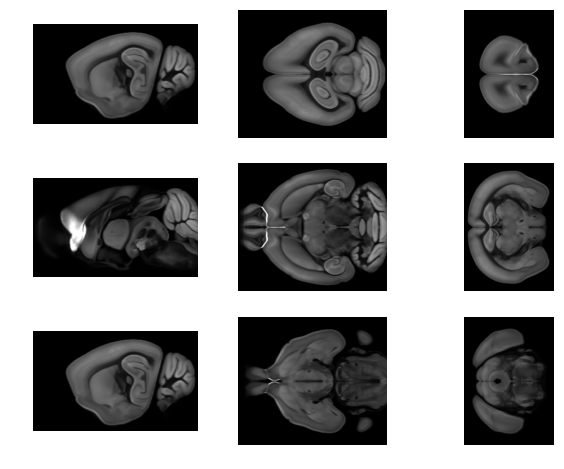

In [4]:
ndreg.imgShow(atlas)

## Half Atlas

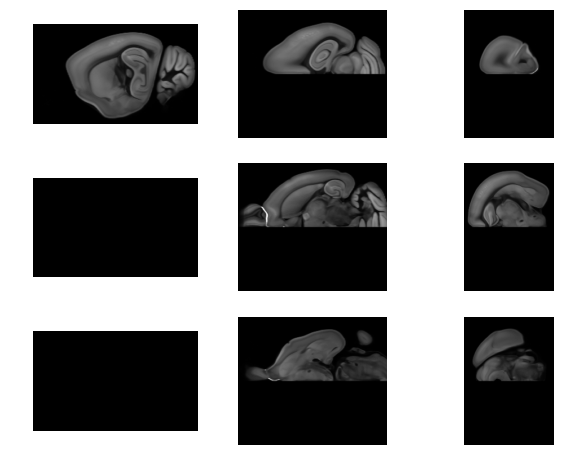

In [5]:
ndreg.imgShow(half_atlas)

## Insula with partially missing nose

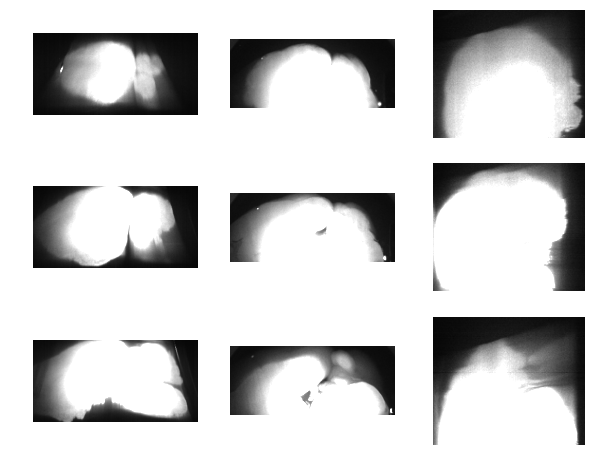

In [6]:
ndreg.imgShow(missing_img, vmax=2500)

## Padded target image

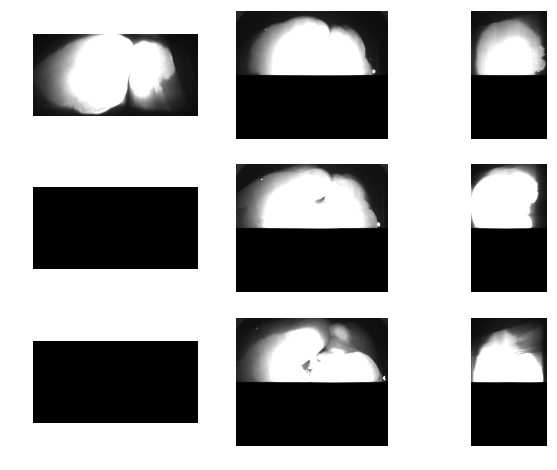

In [7]:
ndreg.imgShow(padded_img, vmax=2500)

## Scenario of known missing data: pad image with an estimate of how much is missing

In [8]:
# Bias correction
mask_dilation_radius = 10 # voxels
mask_bc = sitk.BinaryDilate(pre.create_mask(padded_img, use_triangle=True), mask_dilation_radius)
img_bc, bias = pre.correct_bias_field(padded_img, scale=0.25, spline_order=4, mask=mask_bc,
                                     num_control_pts=[5,5,5],
                                     niters=[50, 50, 50, 50])
atlas_n = sitk.Normalize(atlas)
half_atlas_n = sitk.Normalize(half_atlas)
img_bc_n = sitk.Normalize(img_bc)

## With full atlas

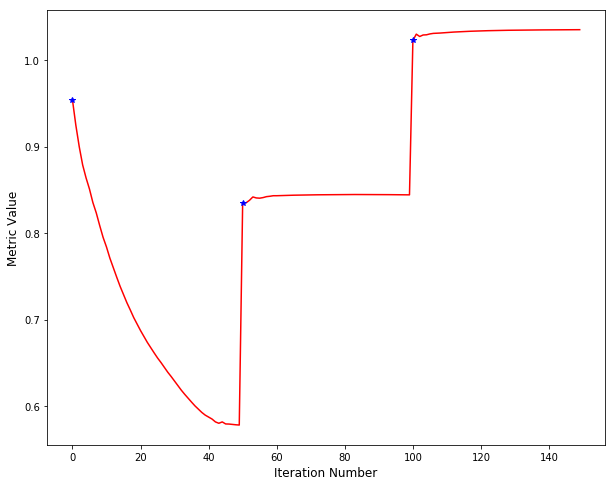

In [66]:
# Compute affine transform
final_transform_full_atlas = reg.register_affine(atlas_n,
                                    img_bc_n,
                                    learning_rate=1e-1,
                                    grad_tol=4e-6,
                                    use_mi=False,
                                    iters=50,
                                    shrink_factors=[4,2,1],
                                    sigmas=[0.4, 0.2, 0.1],
                                    verbose=True)

In [67]:
atlas_affine_full_atlas = reg.resample(atlas, final_transform_full_atlas, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))


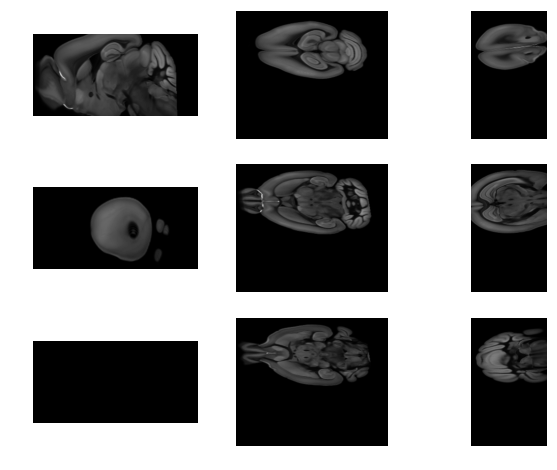

In [68]:
ndreg.imgShow(atlas_affine_full_atlas)

In [70]:
# whiten the images
full_atlas_affine_w = sitk.AdaptiveHistogramEqualization(atlas_affine_full_atlas, [10,10,10], alpha=0.25, beta=0.25)
img_bc_w = sitk.AdaptiveHistogramEqualization(img_bc, [10,10,10], alpha=0.25, beta=0.25)

In [71]:
# LDDMM
e = 5e-3
s = 0.1
full_atlas_lddmm, field, inv_field = reg.register_lddmm(affine_img=sitk.Normalize(full_atlas_affine_w), 
                                                          target_img=sitk.Normalize(img_bc_w),
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	83237.7, 351.708, 0, 82886 (96.2116%), 5.500000e-03
1.	80091.3, 775.528, 0, 79315.7 (92.0673%), 6.050000e-03
2.	78501.7, 865.239, 0, 77636.5 (90.1181%), 3.327500e-03
3.	78236.7, 884.04, 0, 77352.6 (89.7886%), 9.150625e-04
4.	78156.6, 898.924, 0, 77257.6 (89.6784%), 5.032844e-04
5.	78117.1, 915.884, 0, 77201.2 (89.6128%), 5.536128e-04
6.	77855.1, 935.031, 0, 76920.1 (89.2865%), 6.089741e-04
7.	77437.4, 960.601, 0, 76476.8 (88.772%), 6.698715e-04
8.	76556.9, 994.386, 0, 75562.5 (87.7107%), 7.368587e-04
9.	76106.3, 1032.11, 0, 75074.2 (87.1439%), 8.105445e-04
10.	76074, 1072.9, 0, 75001.1 (87.059%), 8.915990e-04
11.	75707.5, 1122.73, 0, 74584.8 (86.5758%), 9.807589e-04
12.	75682.3, 1149.38, 0, 74532.9 (86.5155%), 5.394174e-04
13.	75541.4, 1177.34, 0, 74364.1 (86.3196%), 5.933591e-04
14.	75120.7, 1207.29, 0, 73913.5 (85.7965%), 6.526950e-04
15.	74409, 1241.34, 0, 73167.7 (84.9309%), 7.

Length = 26.8482
Time = 1202.55s (20.0425m)

Step 4: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	62496.9, 4.55293, 0, 62492.3 (98.6749%), 2.750000e-03
1.	61194.6, 1.23352, 0, 61193.4 (96.6239%), 1.512500e-03
2.	60852.7, 2.66386, 0, 60850 (96.0817%), 1.663750e-03
3.	60632.5, 2.4828, 0, 60630 (95.7342%), 1.830125e-03
4.	60570, 2.4909, 0, 60567.5 (95.6356%), 1.258211e-04
E = 60570 (95.6356%)
Length = 1.81226
Time = 1051.73s (17.5288m)


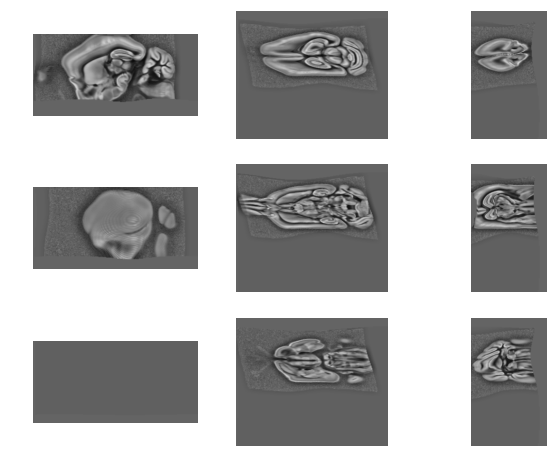

In [72]:
ndreg.imgShow(full_atlas_lddmm)

## With half atlas

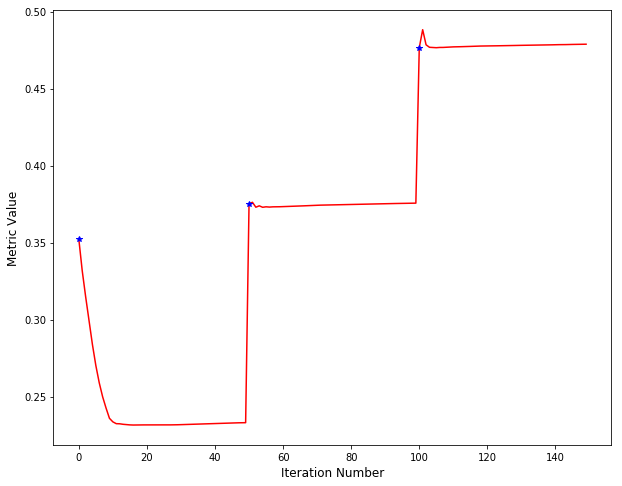

In [9]:
# Compute affine transform
final_transform_half_atlas = reg.register_affine(half_atlas_n,
                                    img_bc_n,
                                    learning_rate=1e-1,
                                    grad_tol=4e-6,
                                    use_mi=False,
                                    iters=50,
                                    shrink_factors=[4,2,1],
                                    sigmas=[0.4, 0.2, 0.1],
                                    verbose=True)

In [10]:
half_atlas_affine = reg.resample(atlas, final_transform_half_atlas, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))


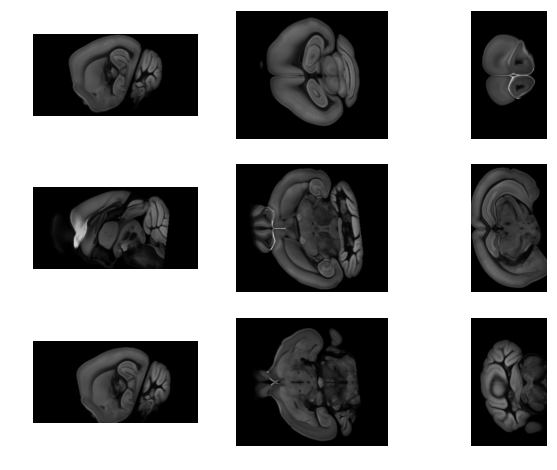

In [11]:
ndreg.imgShow(half_atlas_affine)

In [12]:
# whiten the images
half_atlas_affine_w = sitk.AdaptiveHistogramEqualization(half_atlas_affine, [10,10,10], alpha=0.25, beta=0.25)
img_bc_w = sitk.AdaptiveHistogramEqualization(img_bc, [10,10,10], alpha=0.25, beta=0.25)

In [13]:
# LDDMM
e = 5e-3
s = 0.1
half_atlas_lddmm, field, inv_field = reg.register_lddmm(affine_img=sitk.Normalize(half_atlas_affine_w), 
                                                          target_img=sitk.Normalize(img_bc_w),
                                                          alpha_list=[0.05],
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	88809.6, 285.267, 0, 88524.3 (99.3928%), 5.500000e-03
1.	83760.4, 493.255, 0, 83267.2 (93.4902%), 6.050000e-03
2.	83586.4, 788.376, 0, 82798 (92.9634%), 6.655000e-03
3.	78914.3, 1182.55, 0, 77731.7 (87.2752%), 7.320500e-03
4.	76738.5, 1363.23, 0, 75375.3 (84.6294%), 4.026275e-03
5.	75291.2, 1457.83, 0, 73833.3 (82.8982%), 2.214451e-03
6.	74070.3, 1520.06, 0, 72550.3 (81.4576%), 1.217948e-03
7.	73603.3, 1584.36, 0, 72018.9 (80.861%), 1.339743e-03
8.	73058.6, 1644.25, 0, 71414.4 (80.1822%), 1.473717e-03
9.	72592.2, 1678.38, 0, 70913.8 (79.6202%), 8.105445e-04
10.	72415.8, 1719.32, 0, 70696.5 (79.3761%), 8.915990e-04
11.	72289.8, 1765.65, 0, 70524.2 (79.1827%), 9.807589e-04
12.	71979.1, 1819.49, 0, 70159.6 (78.7734%), 1.078835e-03
13.	71588.3, 1888.09, 0, 69700.3 (78.2576%), 1.186718e-03
14.	71146.4, 1972.15, 0, 69174.2 (77.667%), 1.305390e-03
15.	71109.5, 2020.13, 0, 69089.4 (77.5718


Step 4: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	60514.4, 6.01805, 0, 60508.4 (97.5379%), 5.500000e-03
1.	60266, 2.97408, 0, 60263 (97.1423%), 3.025000e-03
2.	60182.7, 7.64828, 0, 60175 (97.0005%), 3.327500e-03
3.	59550, 5.48936, 0, 59544.5 (95.9841%), 1.830125e-03
4.	59425.2, 7.09148, 0, 59418.1 (95.7803%), 2.013138e-03
5.	59372.9, 8.83179, 0, 59364.1 (95.6933%), 2.214451e-03
6.	59306.5, 11.1065, 0, 59295.4 (95.5826%), 2.435896e-03
7.	59253.9, 13.8887, 0, 59240 (95.4932%), 2.679486e-03
8.	59212.1, 17.284, 0, 59194.9 (95.4205%), 2.947435e-03
9.	59121.5, 21.4544, 0, 59100.1 (95.2677%), 3.242178e-03
10.	59054.1, 26.6034, 0, 59027.5 (95.1508%), 3.566396e-03
11.	59048.7, 32.5532, 0, 59016.2 (95.1325%), 3.923035e-03
12.	58877.8, 36.388, 0, 58841.4 (94.8507%), 2.157670e-03
13.	58855.5, 38.3037, 0, 58817.2 (94.8117%), 1.186718e-03
14.	58842.8, 40.5961, 0, 58802.2 (94.7875%), 1.305390e-03
15.	58823.5, 43.2009, 0, 58780.3 (94.7522%), 1.43592

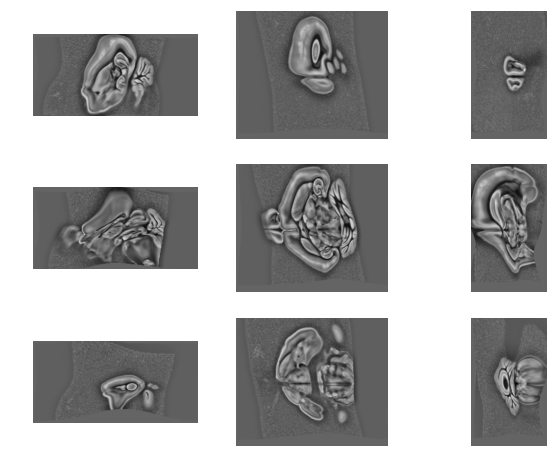

In [14]:
ndreg.imgShow(half_atlas_lddmm)